# Hälsostudie
- **För VG:** Motivera dina metodval i markdown och hänvisa till dokumentation eller annan källa.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Förhandsgranska data

In [ ]:
# Öppnar och läser filen
df = pd.read_csv("health_study_dataset.csv")

# Förhandsgranskar datan
display(df.head())
display(df.describe())
display(df.info())

df.isna().sum()

,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


,id,age,height,weight,systolic_bp,cholesterol,disease
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,49.426250,171.849250,73.413000,149.178625,4.929150,0.058750
std,231.0844,14.501118,9.804259,13.685059,12.793360,0.848413,0.235303
min,1.0000,18.000000,144.400000,33.700000,106.800000,2.500000,0.000000
25%,200.7500,39.000000,164.775000,64.800000,140.900000,4.327500,0.000000
50%,400.5000,50.000000,171.350000,73.200000,149.400000,4.970000,0.000000
75%,600.2500,59.000000,178.925000,82.600000,157.600000,5.482500,0.000000
max,800.0000,90.000000,200.400000,114.400000,185.900000,7.880000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB


None

id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64

## Beskrivande analys

- Räkna ut medel, median, min och max för: age, weight, height, systolic_bp, cholesterol.
- Skapa minst 3 olika grafer (t.ex. histogram över blodtryck, boxplot över vikt per kön, stapeldiagram över andelen rökare).

In [30]:
# Tar fram statistik för hälsodata
columns = ["age", "weight", "height", "systolic_bp", "cholesterol"]
data = df[columns]

statistics = pd.DataFrame({
    "Medel": data.mean(),
    "Median": data.median(),
    "Min": data.min(),
    "Max": data.max()
}).round(2)

statistics.style \
    .set_caption("<h2> Översikt - Statistik för hälsodata") \
    .format("{:.2f}")

,Medel,Median,Min,Max
age,49.43,50.00,18.00,90.00
weight,73.41,73.20,33.70,114.40
height,171.85,171.35,144.40,200.40
systolic_bp,149.18,149.40,106.80,185.90
cholesterol,4.93,4.97,2.50,7.88


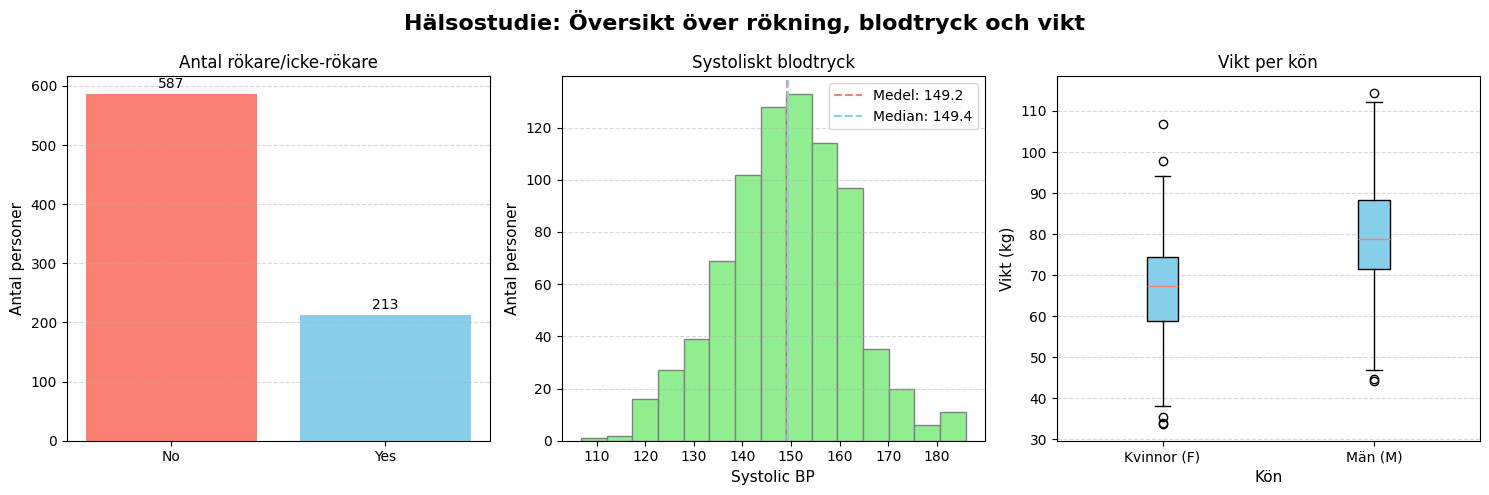

In [33]:
# SKAPAR FIGUR MED 1 RAD OCH 3 KOLUMNER (GRAFER)
# ========================
figs, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)

# SUBPLOT 1: Bar chart för rökare
# ========================
ax1 = axes[0]
counts = df["smoker"].value_counts()
bars = ax1.bar(counts.index, counts.values, color=['salmon', 'skyblue'])

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)),
             ha='center', va='bottom', fontsize=10)

ax1.set_title("Antal rökare/icke-rökare", fontsize=12)
ax1.set_ylabel("Antal personer", fontsize=11)
ax1.grid(True, axis="y", linestyle="--", alpha=0.5)
ax1.tick_params(axis='x')

# SUBPLOT 2: Histogram systoliskt blodtryck
# ========================
ax2 = axes[1]
ax2.hist(df["systolic_bp"], bins=15, color="lightgreen", edgecolor="grey")

mean_bp = df["systolic_bp"].mean()
median_bp = df["systolic_bp"].median()

ax2.axvline(mean_bp, color='salmon', linestyle='dashed', linewidth=1.5, label=f'Medel: {mean_bp:.1f}')
ax2.axvline(median_bp, color='skyblue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_bp:.1f}')

ax2.set_title("Systoliskt blodtryck", fontsize=12)
ax2.set_xlabel("Systolic BP", fontsize=11)
ax2.set_ylabel("Antal personer", fontsize=11)
ax2.grid(True, axis="y", linestyle="--", alpha=0.5)
ax2.legend()

# SUBPLOT 3: Boxplot över vikt per kön
# ========================
ax3 = axes[2]
ax3.boxplot(
    [df.loc[df['sex'] == 'F', 'weight'], df.loc[df['sex'] == 'M', 'weight']],
    tick_labels=["Kvinnor (F)", "Män (M)"],
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='black'),
    medianprops=dict(color='salmon', linewidth=1)
)

ax3.set_title("Vikt per kön", fontsize=12)
ax3.set_xlabel("Kön", fontsize=11)
ax3.set_ylabel("Vikt (kg)", fontsize=11)
ax3.grid(True, axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Hälsostudie: Översikt över rökning, blodtryck och vikt", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Individer med sjukdomen

- Beräkna andelen personer i datasetet som har sjukdomen.
- Använd numpy för att simulera 1000 slumpade personer med samma sannolikhet för sjukdom.
- Jämför den simulerade andelen med den verkliga andelen i datasetet.

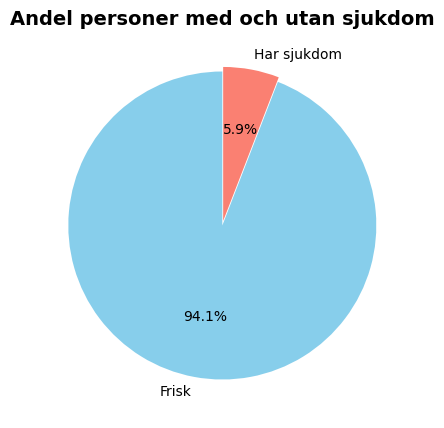

In [42]:
# SKAPAR ETT CIRKELDIAGRAM ÖVER PERSONER MED SJUKDOMEN
# ========================
disease_counts = df["disease"].value_counts().sort_index()

plt.figure(figsize=(5, 5))
plt.pie(
    disease_counts.values,
    labels=["Frisk", "Har sjukdom"],
    autopct="%1.1f%%",
    colors=["skyblue", "salmon"],
    startangle=90,
    explode=(0, 0.03)
)
plt.title("Andel personer med och utan sjukdom", fontsize=14, fontweight='bold')
plt.show()

## Konfidensintervall

- Beräkna ett konfidensintervall för medelvärdet av systolic_bp (t.ex. med normalapproximation eller bootstrap, som vi gått igenom på kursen).
- **För VG:** Beräkna konfidensintervallet med två olika metoder (t.ex. normalapproximation och bootstrap) och jämför resultaten.

## Hypotesprövning

- Testa hypotesen: ”Rökare har högre medel-blodtryck än icke-rökare.”
- Använd en av metoderna vi gått igenom (t.ex. bootstrap eller enkel t-test-funktion).
- Förklara kort resultatet i en markdown-ruta.
- **För VG**: Gör en simulering för att undersöka hur säkert ditt hypotes­test är (t.ex. hur ofta testet hittar en skillnad när den finns → power).